## **Twitter Emotion Recognition using RNN**

---

[Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


## 1. Installing Hugging Face's nlp package

In [1]:
%pip install nlp

Note: you may need to restart the kernel to use updated packages.


## 2. Importing the libraries

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## 3. Importing the Dataset

In [3]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## 4. Tokenizing the Tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)
print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## 5. Padding and Truncating Sequences

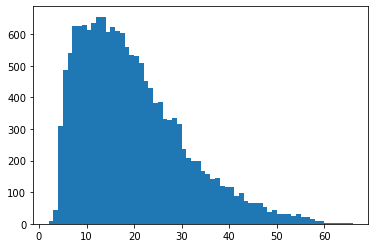

In [11]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [14]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [15]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## 6. Preparing the Labels

In [16]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'anger', 'fear', 'love', 'sadness'}


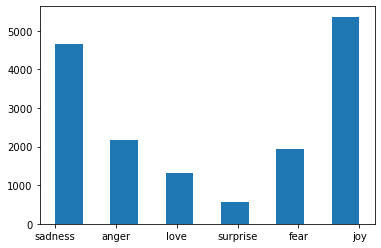

In [17]:
plt.hist(labels, bins=11)
plt.show()

In [18]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [19]:
classes_to_index

{'surprise': 0, 'joy': 1, 'anger': 2, 'fear': 3, 'love': 4, 'sadness': 5}

In [20]:
index_to_classes

{0: 'surprise', 1: 'joy', 2: 'anger', 3: 'fear', 4: 'love', 5: 'sadness'}

In [21]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [22]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


## 7. Creating the Model

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## 8. Training the Model

In [24]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [25]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [26]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 [==============================] - 39s 57ms/step - loss: 1.3082 - accuracy: 0.4749 - val_loss: 0.8693 - val_accuracy: 0.6810
Epoch 2/15
500/500 [==============================] - 25s 51ms/step - loss: 0.6294 - accuracy: 0.7488 - val_loss: 0.6539 - val_accuracy: 0.7525
Epoch 3/15
500/500 [==============================] - 26s 53ms/step - loss: 0.4500 - accuracy: 0.8385 - val_loss: 0.5571 - val_accuracy: 0.8140
Epoch 4/15
500/500 [==============================] - 25s 50ms/step - loss: 0.3021 - accuracy: 0.8989 - val_loss: 0.4861 - val_accuracy: 0.8395
Epoch 5/15
500/500 [==============================] - 26s 52ms/step - loss: 0.2041 - accuracy: 0.9373 - val_loss: 0.3905 - val_accuracy: 0.8855
Epoch 6/15
500/500 [==============================] - 25s 51ms/step - loss: 0.1360 - accuracy: 0.9599 - val_loss: 0.4172 - val_accuracy: 0.8760
Epoch 7/15
500/500 [==============================] - 28s 56ms/step - loss: 0.1133 - accuracy: 0.9651 - val_loss: 0.4324 - val_accuracy:

## 9. Evaluating the Model

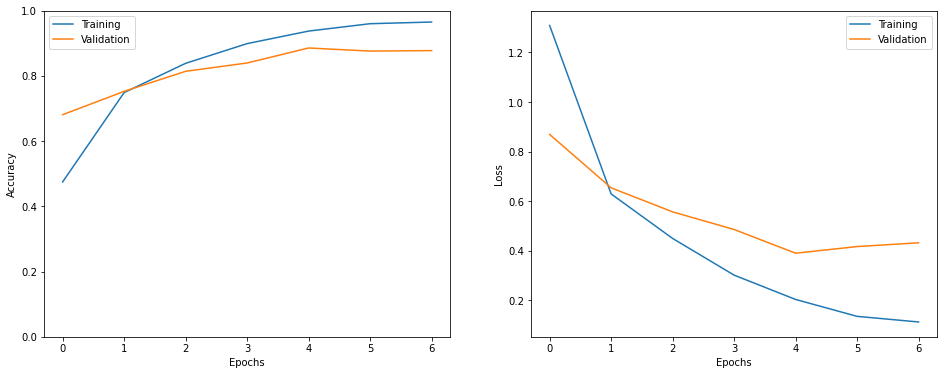

In [27]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
show_history(h)

In [28]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [29]:
eval = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 22ms/step - loss: 0.4191 - accuracy: 0.8725


In [30]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]

  print('Predicted Emotion:', index_to_classes.get(p), '\n')

Tweet: im feeling generous this week
Actual Emotion: joy


AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))

NameError: name 'preds' is not defined